In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
dire = {'up': 1,'down': -1, 'nan':0,'data':0,'none':3,'both':2,'flat':4} #none= narrow sideways, both=wide sideways
def wwma(values, n):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/n, adjust=False).mean()

def atr_percent(df, n=14):
    data = df.copy()
    high = data.High
    low = data.Low
    close = data.Close
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)/close.shift()
    atr = wwma(tr, n)
    return atr


In [3]:
#folio,folio1 = [],[]
ret=pd.DataFrame()
n=0
f=1
inputs= {}
for f in range(1,14):
    tinputs = pd.read_excel('hs20210214-100-3y-'+str(f)+'.xls',sheet_name=None)#load multiple sheets in a dict
    inputs.update(tinputs)
symbols1 = list(inputs.keys())
#[plt.plot(folio1[x]['Close'][:60]) for x in symbols]

In [4]:
#symbols1
#inputs

In [5]:
folio1 = {}
for e in symbols1:
    i = inputs[e]
    i.fillna(0)
    i['Date'] = pd.to_datetime(i['Date'])
    if i.loc[0]['NI'] != 1:
        i['NI'] = [dire[str(item)] for item in i['NI']] 
    i = i.sort_values('Date',ascending=True)
    i = i.reset_index(drop=True)
    #i['returns'] = (i.Close-i.Open)/i.Open 
    i['atr'] = atr_percent(i)
    #ret[symbols1[n]] = (i.returns + 1).cumprod()
    n=n+1
    i.fillna(0)
    folio1[e]=i
print(n)
#pd.MultiIndex.from_arrays(symbols,folio)
print(len(folio1))
#plt.figure(figsize=(20,10))
#plt.plot(ret)
#plt.legend(symbols1,loc='upper left')
#plt.show()

1271
1271


In [6]:
#i

In [7]:
folio=folio1
symbols=symbols1
#pd.options.display.float_format = '${:,.2f}'.format
pd.options.display.float_format = '{:,.2f}'.format

1271
# selected:  1093
       symbol  sharpe      total   totalBH       pf nwin nloose    tprofit     tloss      lastp
175     BRK-A    7.23 192,021.10 67,500.00    20.55   88     12 201,842.62 -9,821.52 359,750.00
72       AMZN    9.43   3,591.72  1,863.20    26.23  154     21   3,734.10   -142.38   3,233.31
158      BKNG    9.85   2,611.22    352.72    29.74  139     19   2,702.08    -90.86   2,110.01
724      MELI    9.47   2,033.61  1,576.49    49.48  147     12   2,075.55    -41.94   1,880.00
491     GOOGL   10.56   1,968.66  1,040.89    49.08  142     11   2,009.60    -40.94   2,073.57
1009     SHOP    8.19   1,688.66  1,329.43    41.18  155     18   1,730.70    -42.03   1,431.39
121       AZO    9.92   1,657.27    434.77    57.32  151      9   1,686.69    -29.42   1,143.33
259       CMG    9.35   1,540.12  1,276.37    81.15  146     10   1,559.34    -19.22   1,522.00
764       MTD   10.73   1,456.03    606.97    93.29  172      9   1,471.81    -15.78   1,199.91
982       SAM    

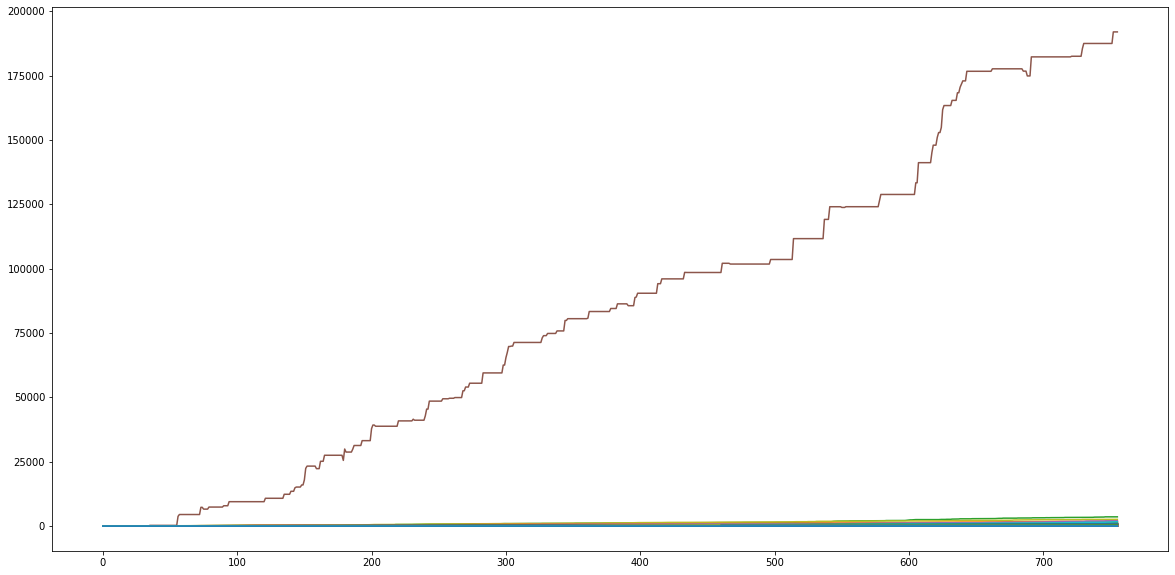

In [30]:
plot=False
n=0
strategy = pd.DataFrame()
strategyDaily = pd.DataFrame()
dayReturnPercent = pd.DataFrame()
buyHold= pd.DataFrame()
print(len(symbols))
pffilterlist={}
starSymbols1=[]
outSymbols1=[]
raw_stats=pd.DataFrame(columns=('symbol', 'sharpe', 'total','totalBH','pf','nwin','nloose','tprofit','tloss','lastp'))
#symbols = symbols[:100]
for s in symbols:
    i = folio[s]
    i['pdHigh'] = i.pHigh.pct_change()
    i['pdLow'] = i.pLow.pct_change()
    i['returns'] = 0.8*(i.Close-i.Open)#/i.Open  #%slippage on open
    i['ovGap'] = (i.Open - i.Close.shift(1))/i.Close.shift(1)
    i['rvol'] = i.Volume/i.Volume.rolling(8).mean()
   
    trades = (i.pdLow > 0.00) & (i.pdHigh > 0.005) & (i['NI'] >0) & (i.rvol.shift(1) > 0.8) & (i.ovGap < 0.02)# & (i.atr.shift(1) > 0.1)
    #print()

    name=symbols[n]
    trd = i.returns * trades
    #print(trd[730:])
    strategy[name] = (i.returns * trades).cumsum()#.cumprod()  # backtesting
    buyHold[name] = i.Close.diff().cumsum()#(i.returns).cumsum()  # benchmark

    dailyReturns = (i.returns * trades)
    strategyDaily[name] = dailyReturns
    #dayReturnPercent[name] = (dailyReturns+1).cumprod()

    sharpe  = dailyReturns.mean()/dailyReturns.std()
    sharpe  = sharpe*(len(dailyReturns)**0.5) #annual
    total   = strategy[name].max() #dailyReturns.sum()
    totalBH = buyHold[name].iat[-1]
    nloose  = (dailyReturns <0).sum()
    nwin    = (dailyReturns >0).sum()
    tprofit = (dailyReturns*(dailyReturns >0)).sum()
    tloss   = (dailyReturns*(dailyReturns <0)).sum()
    lastp    = i.Low.iat[-1]
    pf=0
    if nloose != 0:
        pf = tprofit/abs(tloss)
    else:
        pf = 100
    inout=0

    if (nwin >10) & (sharpe >= 5) & (i.Low.max() < 300):
        starSymbols1.append(s)
        if plot and n<20:
            plt.figure(figsize=(20,5))
            plt.title('returns '+symbols[n])
#           plt.ylabel("multiple of 1$ invest")
            plt.plot(strategy[symbols[n]], label="strategy")
            plt.ylabel("percent cummulative")
            #plt.plot(dayReturnPercent[symbols[n]], label="dayReturnPercent")
            plt.plot(buyHold[symbols[n]], label="Buy&Hold")
            
            plt.legend(['strategy','buy&hold'])
            plt.show()
    else:
        outSymbols1.append(s)
    row=[s,sharpe,total,totalBH,pf,nwin,nloose,tprofit,tloss,lastp]
    raw_stats.loc[n]=row
#print(row)
    n=n+1
plt.figure(figsize=(20,10))
plt.plot(strategy)
#plt.legend(symbols)

print('# selected: ',len(starSymbols1))
sh=raw_stats.sort_values(['tprofit','sharpe'],ascending=False)
with pd.option_context('display.max_rows', None, 'display.max_columns', 11,'display.width',140):  # more options can be specified also
    print(sh)
%store sh
%store starSymbols1
#strategy['ADBE']   

In [31]:
#s=stats.sort_values(['nwin'],ascending=False)[:int(len(stats)/4)]
#s.symbol
stats=raw_stats.loc[(raw_stats.lastp<300) & (raw_stats.lastp>5),:]
print(stats.lastp.mean())
stats.sort_values('lastp')


72.9644982649679


,symbol,sharpe,total,totalBH,pf,nwin,nloose,tprofit,tloss,lastp
586,INM,4.68,55.17,-26.02,427.51,67,2,55.30,-0.13,5.01
178,BSMX,9.10,10.92,-2.24,34.98,115,14,11.19,-0.32,5.03
769,MUFG,7.09,3.05,-2.02,17.57,85,11,3.23,-0.18,5.07
1157,UEPS,6.84,8.73,-4.38,122.28,71,4,8.80,-0.07,5.07
155,BKD,7.88,15.66,-4.21,79.24,108,4,15.85,-0.20,5.11
...,...,...,...,...,...,...,...,...,...,...
1234,WST,9.05,290.28,201.01,59.52,146,11,295.24,-4.96,289.15
928,PYPL,9.60,238.55,223.40,23.32,151,23,249.24,-10.69,289.32
29,ADSK,10.77,425.70,195.35,187.71,167,5,427.98,-2.28,295.32
800,NOC,9.65,553.35,-46.00,251.61,144,5,555.56,-2.21,296.11


position per day #  270


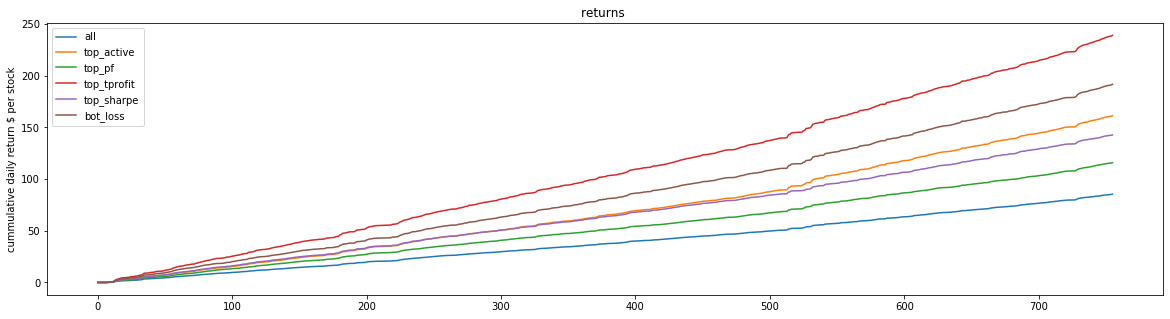

In [44]:
dailyReturn = pd.DataFrame()
days=[]
percentile =0.25
for x in range(0,len(strategy)):
    yst = strategyDaily.loc[x,:]
    #print(yst,yst.sum())
    row = len(dailyReturn)
    dailyReturn.loc[row,'all']=strategyDaily.loc[x,starSymbols1].sum()/len(strategyDaily.columns)
    dailyReturn.loc[row,'top_active']=strategyDaily.loc[x,stats.sort_values(['nwin'],ascending=False)[:int(len(stats)*percentile)].symbol].sum()/int(len(stats)*percentile)
    dailyReturn.loc[row,'top_pf']=strategyDaily.loc[x,stats.sort_values(['pf'],ascending=False)[:int(len(stats)*percentile)].symbol].sum()/int(len(stats)*percentile)
    dailyReturn.loc[row,'top_tprofit']=strategyDaily.loc[x,stats.sort_values(['tprofit'],ascending=False)[:int(len(stats)*percentile)].symbol].sum()/int(len(stats)*percentile)
    dailyReturn.loc[row,'top_sharpe']=strategyDaily.loc[x,stats.sort_values(['sharpe'],ascending=False)[:int(len(stats)*percentile)].symbol].sum()/int(len(stats)*percentile)
    dailyReturn.loc[row,'bot_loss']=strategyDaily.loc[x,stats.sort_values(['tloss'],ascending=True)[:int(len(stats)*percentile)].symbol].sum()/int(len(stats)*percentile)
dailyReturn.fillna(0)
plt.figure(figsize=(20,5))
plt.title('returns ')
plt.plot(dailyReturn['all'].cumsum(), label="all")
#plt.plot(dailyReturn['stars'].cumsum(), label="stars")
plt.plot(dailyReturn['top_active'].cumsum(), label="top_active")
plt.plot(dailyReturn['top_pf'].cumsum(), label="top_pf")
plt.plot(dailyReturn['top_tprofit'].cumsum(), label="top_tprofit")
plt.plot(dailyReturn['top_sharpe'].cumsum(), label="top_sharpe")
plt.plot(dailyReturn['bot_loss'].cumsum(), label="bot_loss")
plt.ylabel("cummulative daily return $ per stock")
plt.legend()
days
dailyReturn
print ('position per day # ',int(len(stats)*percentile))

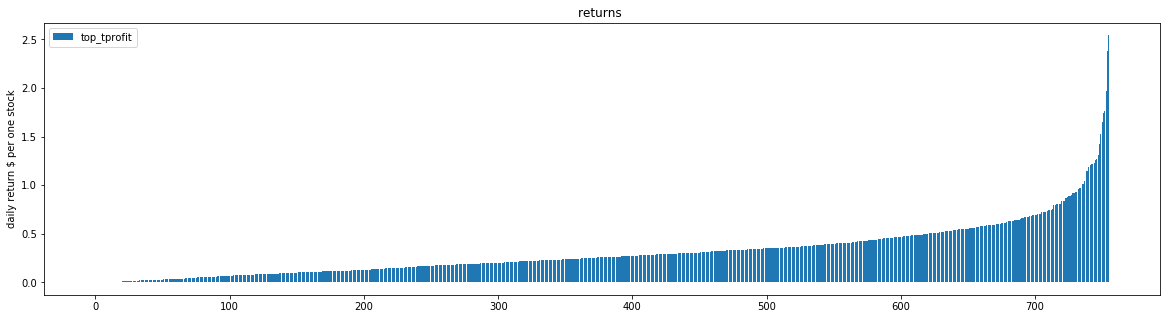

In [45]:
plt.figure(figsize=(20,5))
plt.title('returns ')
#plt.plot(dailyReturn['all'].cumsum(), label="all")
#plt.plot(dailyReturn['stars'].cumsum(), label="stars")
#plt.plot(dailyReturn['top_active'].cumsum(), label="top_active")
#plt.plot(dailyReturn['top_pf'].cumsum(), label="top_pf")
dv = dailyReturn.sort_values('top_tprofit')['top_tprofit'].reset_index(drop=True)
plt.bar(dv.index,dv, label="top_tprofit")
#plt.plot(dailyReturn['top_sharpe'], label="top_sharpe")
#plt.plot(dailyReturn['bot_loss'], label="bot_loss")
plt.ylabel("daily return $ per one stock")
plt.legend()


Index(['all', 'top_active', 'top_pf', 'top_tprofit', 'top_sharpe', 'bot_loss'], dtype='object')


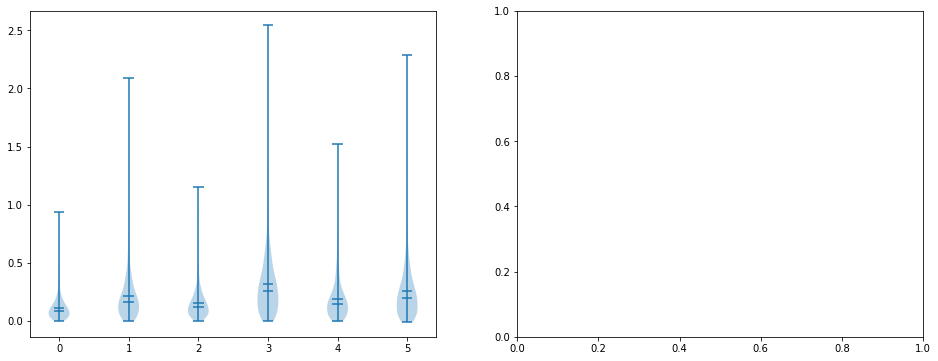

In [46]:
print(dailyReturn.columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax = axes[0].violinplot(dailyReturn.to_numpy(), range(0,len(dailyReturn.columns)), points=len(dailyReturn), widths=0.3,
                      showmeans=True, showextrema=True, showmedians=True)

In [47]:
goodboys = stats.sort_values(['tprofit'],ascending=False)[:int(len(stats)*percentile)].symbol.tolist()
print(len(goodboys))
print(goodboys)
%store goodboys

270
['NBR', 'NOC', 'STMP', 'ANTM', 'ESS', 'BA', 'PODD', 'VRTX', 'ICUI', 'BIIB', 'ADSK', 'IAC', 'LGND', 'WDAY', 'RETA', 'CI', 'TDOC', 'MOH', 'BDX', 'URI', 'PH', 'SBAC', 'AMT', 'IPGP', 'PSA', 'MED', 'TEAM', 'MCO', 'MASI', 'AMGN', 'IRTC', 'COHR', 'MSGS', 'GWPH', 'MRTX', 'FDX', 'NSC', 'OLED', 'ALNY', 'HD', 'RARE', 'APD', 'CMI', 'PXD', 'SAGE', 'FB', 'CME', 'QDEL', 'AVB', 'SNPS', 'CACI', 'WHR', 'SRPT', 'WLTW', 'CRM', 'EXAS', 'WAT', 'BLUE', 'WST', 'ROK', 'ERIE', 'BIDU', 'SPLK', 'SYK', 'AON', 'CCMP', 'ODFL', 'LH', 'LHX', 'ASND', 'EL', 'CAT', 'SWK', 'AMP', 'NBIX', 'AAP', 'ECL', 'CBRL', 'STZ', 'BABA', 'ICLR', 'CASY', 'PLCE', 'TTWO', 'VRSN', 'MORN', 'JAZZ', 'IIPR', 'SGEN', 'LEA', 'MSI', 'CLX', 'UTHR', 'SBNY', 'MMM', 'SQ', 'GD', 'ACN', 'NVCR', 'MHK', 'FIVE', 'VMW', 'PFPT', 'PYPL', 'DOCU', 'HCA', 'ITW', 'NDSN', 'GPN', 'DHR', 'MCD', 'BPMC', 'EFX', 'WYNN', 'DG', 'RMD', 'ALXN', 'UHS', 'MTB', 'SNA', 'UNP', 'FTNT', 'KSU', 'RGEN', 'LSTR', 'TNDM', 'AXON', 'CCI', 'NXST', 'JKHY', 'LPI', 'HON', 'FFIV', 'JBHT

In [48]:
a = stats.sort_values('total')
m = a.query('symbol in @goodboys')
len(m)

270

270

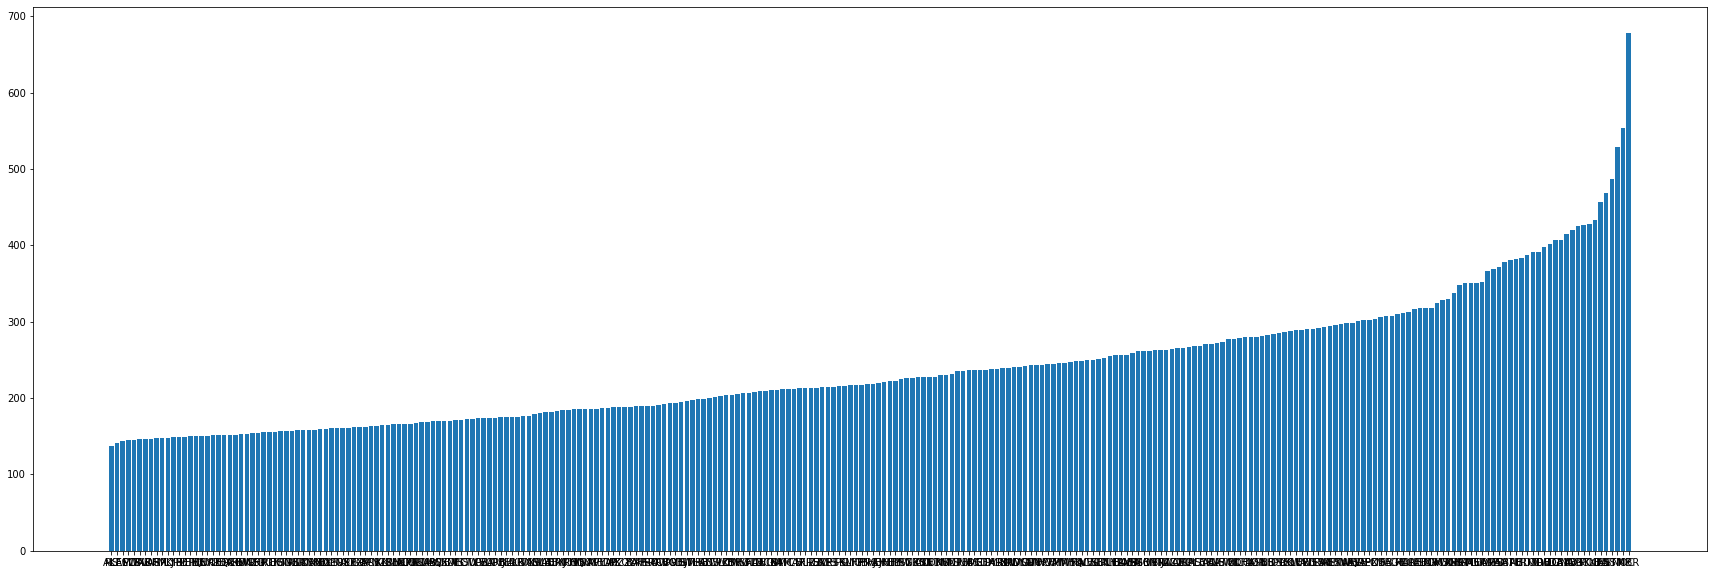

In [49]:

plt.figure(figsize=(30,10))
plt.bar(m.symbol,m.total)
#plt.legend(symbols)
m.columns.tolist()
len(m)

In [50]:
setup = m.symbol.tolist()
print(setup)

['RS', 'AKAM', 'LECO', 'FSLR', 'PTSI', 'WAB', 'TXRH', 'VAR', 'DGX', 'FMC', 'PKI', 'LYB', 'JPM', 'PEP', 'DTE', 'EMN', 'BBY', 'QURE', 'EXPE', 'DD', 'ETR', 'CREE', 'QCOM', 'ARWR', 'IONS', 'MCHP', 'ZG', 'FRT', 'TGT', 'ROST', 'EOG', 'NTRS', 'SNBR', 'RTX', 'LITE', 'CDNS', 'CNMD', 'AMG', 'KEYS', 'DLTR', 'XLNX', 'POST', 'ADI', 'PPG', 'EXP', 'GRPN', 'ACB', 'BRK-B', 'Z', 'XLRN', 'KMX', 'CHKP', 'LOPE', 'ADUS', 'COLM', 'GRUB', 'NDAQ', 'ABC', 'PSX', 'WSM', 'IBM', 'DIS', 'FIS', 'LOW', 'CTXS', 'UPS', 'GBT', 'VLO', 'CPE', 'ARNA', 'JE', 'BLKB', 'DRI', 'LIVN', 'TXN', 'CSL', 'KMB', 'SLAB', 'ADP', 'CRI', 'BMRN', 'XPO', 'JOBS', 'HQY', 'INCY', 'NXPI', 'AVY', 'MEDP', 'CW', 'AIZ', 'PKG', 'PZZA', 'YY', 'BXP', 'CRSP', 'HSY', 'TROW', 'TRV', 'ACOR', 'CBOE', 'PVH', 'CDW', 'SJM', 'GTLS', 'THO', 'IRBT', 'ADS', 'BCPC', 'SWKS', 'LLY', 'ZBH', 'FNV', 'MSFT', 'RGLD', 'ALB', 'FANG', 'MCK', 'ETSY', 'EA', 'VMC', 'MTCH', 'MAR', 'V', 'DLR', 'FIZZ', 'REX', 'SRE', 'ICPT', 'VRSK', 'SPG', 'RL', 'SMG', 'IFF', 'CB', 'PNC', 'PRAH', 

In [51]:
%store setup

Stored 'setup' (list)
